In [48]:
import numpy as np
import matplotlib.pyplot as plt
import os
import urllib.request
from matplotlib.font_manager import fontManager
import matplotlib
import pandas as pd
import properscoring as ps
from scipy.stats import t
import gc

In [49]:
def plot_timeseries_with_uncertainty(
    ground_truth,
    median_prediction,
    prediction_samples,
    baseline_prediction,
    node_idx,
    save_path="prediction_visualization.png"
):
    """
    绘制单个站点的时序预测与不确定性区间，并与基线模型对比。

    参数:
    - ground_truth (np.array): 形状为 (pred_len,) 的未来真实值。
    - median_prediction (np.array): 形状为 (pred_len,) 的中位数预测值。
    - prediction_samples (np.array): 形状为 (num_samples, pred_len) 的多次采样预测结果。
    - baseline_prediction (np.array): 形状为 (pred_len,) 的基线模型预测值。
    - node_idx (int): 要可视化的充电桩（节点）的索引。
    - save_path (str): 图片保存路径。
    """
    plt.rcParams['font.sans-serif'] = ['微软雅黑', 'SimHei', 'Heiti TC', 'PingFang SC', 'sans-serif']  # 指定一个支持中文的字体，例如“黑体”
    plt.rcParams['axes.unicode_minus'] = False   # 解决负号'-'显示为方块的问题
    
    pred_len = len(ground_truth)

    # --- 计算不确定性区间 ---
    # 沿样本维度（axis=0）计算第5和第95百分位数
    lower_bound = np.percentile(prediction_samples, 5, axis=0)
    upper_bound = np.percentile(prediction_samples, 95, axis=0)

    # --- 开始绘图 ---
    # 设置更美观的绘图风格
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 7))

    # 创建时间轴
    future_time = np.arange(pred_len)

    # 1. 绘制未来真实值
    ax.plot(future_time, ground_truth, 'r-', linewidth=2, label='Ground Truth')

    # 2. 绘制我们模型的中位数预测
    ax.plot(future_time, median_prediction, 'b-', linewidth=2, label='Our Model Median')
    
    # 3. 绘制基线模型的预测
    ax.plot(future_time, baseline_prediction, 'g--', linewidth=2, label='Baseline: TimeXer')

    # 4. 绘制我们模型的不确定性区间（阴影区域）
    ax.fill_between(
        future_time, lower_bound, upper_bound, color='blue', alpha=0.2,
        label='Our Model 90% C.I.'
    )

    # --- 设置图表标题和标签 ---
    ax.set_title(f'Charging Pile {node_idx} Prediction Comparison', fontsize=18)
    ax.set_xlabel('Prediction Time Step', fontsize=12)
    ax.set_ylabel('Occupancy', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True)
    
    # 调整布局并保存图片
    plt.tight_layout()
    plt.show()
    plt.savefig(save_path)
    print(f"可视化图表已保存至: {save_path}")

In [50]:
def calculate_metrics(y_true, y_pred_median, y_pred_samples):

    y_pred_samples= y_pred_samples.astype(np.float16)
    metrics = {}
    metrics['mae'] = float(np.mean(np.abs(y_pred_median - y_true)))
    metrics['rmse'] = float(np.sqrt(np.mean((y_pred_median - y_true)**2)))
    rae_numerator = np.sum(np.abs(y_pred_median - y_true))
    rae_denominator = np.sum(np.abs(np.mean(y_true) - y_true))
    metrics['rae'] = float(rae_numerator / (rae_denominator + 1e-9))
    non_zero_mask = y_true != 0
    metrics['mape'] = float(np.mean(np.abs((y_pred_median[non_zero_mask] - y_true[non_zero_mask]) / y_true[non_zero_mask])) * 100) if np.any(non_zero_mask) else 0.0
    gc.collect()
    # metrics['crps'] = float(ps.crps_ensemble(y_true, y_pred_samples.transpose(1, 0, 2, 3), axis=0).mean())

    horizon_metrics = []
    for i in range(y_true.shape[1]): # 遍历预测长度
        y_true_h, y_pred_median_h, y_pred_samples_h = y_true[:, i, :], y_pred_median[:, i, :], y_pred_samples[:, :, i, :]
        mae_h = float(np.mean(np.abs(y_pred_median_h - y_true_h)))
        rmse_h = float(np.sqrt(np.mean((y_pred_median_h - y_true_h)**2)))
        rae_num_h = np.sum(np.abs(y_pred_median_h - y_true_h))
        rae_den_h = np.sum(np.abs(np.mean(y_true_h) - y_true_h))
        rae_h = float(rae_num_h / (rae_den_h + 1e-9))
        non_zero_mask_h = y_true_h != 0
        if np.any(non_zero_mask_h):
            mape_h = float(np.mean(np.abs((y_pred_median_h[non_zero_mask_h] - y_true_h[non_zero_mask_h]) / y_true_h[non_zero_mask_h])) * 100)
        else:
            mape_h = 0.0
        # crps_h = float(ps.crps_ensemble(y_true_h, y_pred_samples_h.transpose(1, 0, 2), axis=0).mean())
        # horizon_metrics.append([f't+{i+1}', mae_h, rmse_h, rae_h, mape_h, crps_h])
        horizon_metrics.append([f't+{i+1}', mae_h, rmse_h, rae_h, mape_h])

    # df = pd.DataFrame(horizon_metrics, columns=['Horizon', 'MAE', 'RMSE', 'RAE', 'MAPE', 'CRPS'])
    df = pd.DataFrame(horizon_metrics, columns=['Horizon', 'MAE', 'RMSE', 'RAE', 'MAPE'])
    metrics['horizon_metrics'] = df.to_dict('records')
    return metrics

def print_metrics(metrics):
    print("\n--- Overall Metrics ---")
    print(f"MAE:  {metrics['mae']:.4f}")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"RAE:  {metrics['rae']:.4f}")
    print(f"MAPE: {metrics['mape']:.2f}%")
    # print(f"CRPS: {metrics['crps']:.4f}")
    print("-----------------------\n")
    
    if 'horizon_metrics' in metrics:
        horizon_df = pd.DataFrame(metrics['horizon_metrics'])
        print("--- Horizon-wise Metrics ---")
        print(horizon_df)
        print("----------------------------\n")

    if 'dm_stat' in metrics:
        print("--- Significance Test (Diebold-Mariano) ---")
        print(f"Comparing Your Model against Naive Baseline:")
        print(f"DM Statistic: {metrics['dm_stat']:.4f}, P-value: {metrics['p_value']:.7f}")
        if metrics['p_value'] < 0.05:
            print("Conclusion: Your model is STATISTICALLY SIGNIFICANTLY BETTER than the Naive baseline (p < 0.05).")
        else:
            print("Conclusion: No statistical evidence that your model is better than the Naive baseline (p >= 0.05).")
        print("--------------------------------------------\n")

def dm_test(e1, e2, h=12, crit="MAD"):
    e1, e2 = np.array(e1), np.array(e2)
    # d = np.abs(e1) - np.abs(e2)
    if crit == "MAD":
        d = np.abs(e1) - np.abs(e2)
    elif crit == "MSE":
        d = np.square(e1) - np.square(e2)
    else:
        # 如果传入不支持的参数，则报错
        raise ValueError(f"Unknown criterion: {crit}. Supported values are 'MAD' or 'MSE'.")
    d_mean = np.mean(d)
    n = len(d)
    d_centered = d - d_mean
    acov = np.correlate(d_centered, d_centered, mode="full")[n-1:n+h] / n
    var_d = acov[0] + 2 * np.sum([(1 - lag/(h+1)) * acov[lag] for lag in range(1, h)])
    var_d = max(var_d, 1e-12)
    dm_stat = d_mean / np.sqrt(var_d / n)
    p_value = 1 - t.cdf(dm_stat, df=n-1)
    return dm_stat, p_value



In [58]:

model_predictions = np.load("results/pred_20251120_220329_best_val.npy")
ground_truths = np.load("results/ground_truths.npy")
model_samples = np.load("results/samples_20251120_220329_best_val.npy")
baseline_predictions = np.load("urbanev/TimeXer_predictions.npy")
baseline_predictions = np.concatenate([baseline_predictions[:, :, -1:], baseline_predictions], axis=-1)[:, :, :-1]
baseline_predictions = baseline_predictions[:model_predictions.shape[0]]
model_predictions = model_predictions[:baseline_predictions.shape[0]]
model_samples = model_samples[:baseline_predictions.shape[0]]


In [5]:
ground_truths.shape

(412, 12, 275)

In [6]:
model_predictions.shape

(412, 12, 275)

In [35]:
def restore_sampler_order(data, num_replicas):
    """
    恢复由 DistributedSampler(shuffle=False) 和 gather_object 
    打乱顺序的 .npy 文件。
    """
    
    total_len = data.shape[0]
    other_dims = data.shape[1:]
    
    print(f"加载数据 shape: {data.shape}")
    print(f"总样本数: {total_len}, GPU数量: {num_replicas}")

    # 创建一个空的、和原始数据一样大的数组用于存放恢复后的数据
    restored_data = np.empty_like(data)

    start_idx = 0
    for rank in range(num_replicas):
        # 1. 计算这个 rank 被分配了多少样本
        num_samples_per_rank = int(np.ceil((total_len - rank) / num_replicas))
        
        # 2. 从加载的数据中切片出这个 rank 的数据块
        end_idx = start_idx + num_samples_per_rank
        rank_data_block = data[start_idx:end_idx]
        
        # 3. 将这个数据块 "交错" 插入到新数组的正确位置
        # Rank 0 的数据 (rank=0) 放到 [0::2] (偶数位)
        # Rank 1 的数据 (rank=1) 放到 [1::2] (奇数位)
        restored_data[rank::num_replicas] = rank_data_block
        
        # 更新下一个数据块的起始索引
        start_idx = end_idx

    print(f"恢复顺序完成。新数组 shape: {restored_data.shape}")
    
    return restored_data

    # 验证一下您的数据
    # 您的 shape 是 (412, 12, 275)
    # total_len = 412, num_replicas = 2
    # Rank 0: ceil((412 - 0) / 2) = 206 个样本。将被放到 [0::2]
    # Rank 1: ceil((412 - 1) / 2) = ceil(205.5) = 206 个样本。将被放到 [1::2]
    # start_idx for rank 1 will be 206.
    # data[0:206] -> restored_data[0::2]
    # data[206:412] -> restored_data[1::2]
    # 这完全符合预期。
    
    

In [ ]:
# model_predictions=restore_sampler_order(model_predictions, 2)
# model_samples=restore_sampler_order(model_samples,2)

加载数据 shape: (412, 12, 275)
总样本数: 412, GPU数量: 2
恢复顺序完成。新数组 shape: (412, 12, 275)
加载数据 shape: (412, 40, 12, 275)
总样本数: 412, GPU数量: 2
恢复顺序完成。新数组 shape: (412, 40, 12, 275)


In [59]:
final_metrics = calculate_metrics(ground_truths, model_predictions, model_samples)

In [60]:
print_metrics(final_metrics)


--- Overall Metrics ---
MAE:  0.0171
RMSE: 0.0326
RAE:  0.1376
MAPE: 9.67%
-----------------------

--- Horizon-wise Metrics ---
   Horizon       MAE      RMSE       RAE       MAPE
0      t+1  0.017391  0.034006  0.139876   9.567852
1      t+2  0.018172  0.034807  0.146181  10.215981
2      t+3  0.017544  0.033422  0.141144   9.832197
3      t+4  0.016928  0.032056  0.136179   9.529167
4      t+5  0.017098  0.032416  0.137546   9.605683
5      t+6  0.017029  0.032755  0.137003   9.684987
6      t+7  0.017475  0.033299  0.140603  10.060547
7      t+8  0.017379  0.032820  0.139832   9.992595
8      t+9  0.016264  0.031089  0.130845   9.282950
9     t+10  0.014389  0.027653  0.115740   8.175803
10    t+11  0.015041  0.028297  0.120949   8.598679
11    t+12  0.020560  0.037618  0.165261  11.536369
----------------------------



In [42]:
errors_model = np.abs(ground_truths.flatten() - model_predictions.flatten())
errors_baseline = np.abs(ground_truths.flatten() - baseline_predictions.flatten())
dm_statistic, p_value = dm_test(errors_baseline, errors_model, crit="MSE")
final_metrics['dm_stat'] = dm_statistic
final_metrics['p_value'] = p_value

In [43]:
print_metrics(final_metrics)


--- Overall Metrics ---
MAE:  0.0134
RMSE: 0.0259
RAE:  0.1081
MAPE: 8.75%
-----------------------

--- Horizon-wise Metrics ---
   Horizon       MAE      RMSE       RAE      MAPE
0      t+1  0.014201  0.027387  0.114222  9.463686
1      t+2  0.013427  0.025883  0.108013  9.000944
2      t+3  0.013189  0.025574  0.106101  8.646551
3      t+4  0.013944  0.027200  0.112179  9.086625
4      t+5  0.014634  0.028389  0.117723  9.401502
5      t+6  0.014451  0.027704  0.116265  9.257150
6      t+7  0.013917  0.026095  0.111980  8.988348
7      t+8  0.013403  0.025342  0.107839  8.606427
8      t+9  0.013375  0.025587  0.107602  8.581818
9     t+10  0.013055  0.025468  0.105009  8.272962
10    t+11  0.011239  0.021285  0.090375  7.530395
11    t+12  0.012450  0.023578  0.100074  8.118198
----------------------------

--- Significance Test (Diebold-Mariano) ---
Comparing Your Model against Naive Baseline:
DM Statistic: 231.4472, P-value: 0.0000000
Conclusion: Your model is STATISTICALLY SIGNI

In [53]:
dm_statistic, p_value = dm_test(errors_baseline, errors_model, crit="MAD")
print(f"DM Statistic (MAE): {dm_statistic:.4f}, P-value: {p_value:.7f}")

DM Statistic (MAE): 20.1921, P-value: 0.0000000


### 好的参数

sample_idx_to_plot = 72  
node_idx_to_plot = 201   

sample_idx_to_plot = 1  
node_idx_to_plot = 11 

sample_idx_to_plot = 200 
node_idx_to_plot = 145

sample_idx_to_plot = 55 
node_idx_to_plot = 60

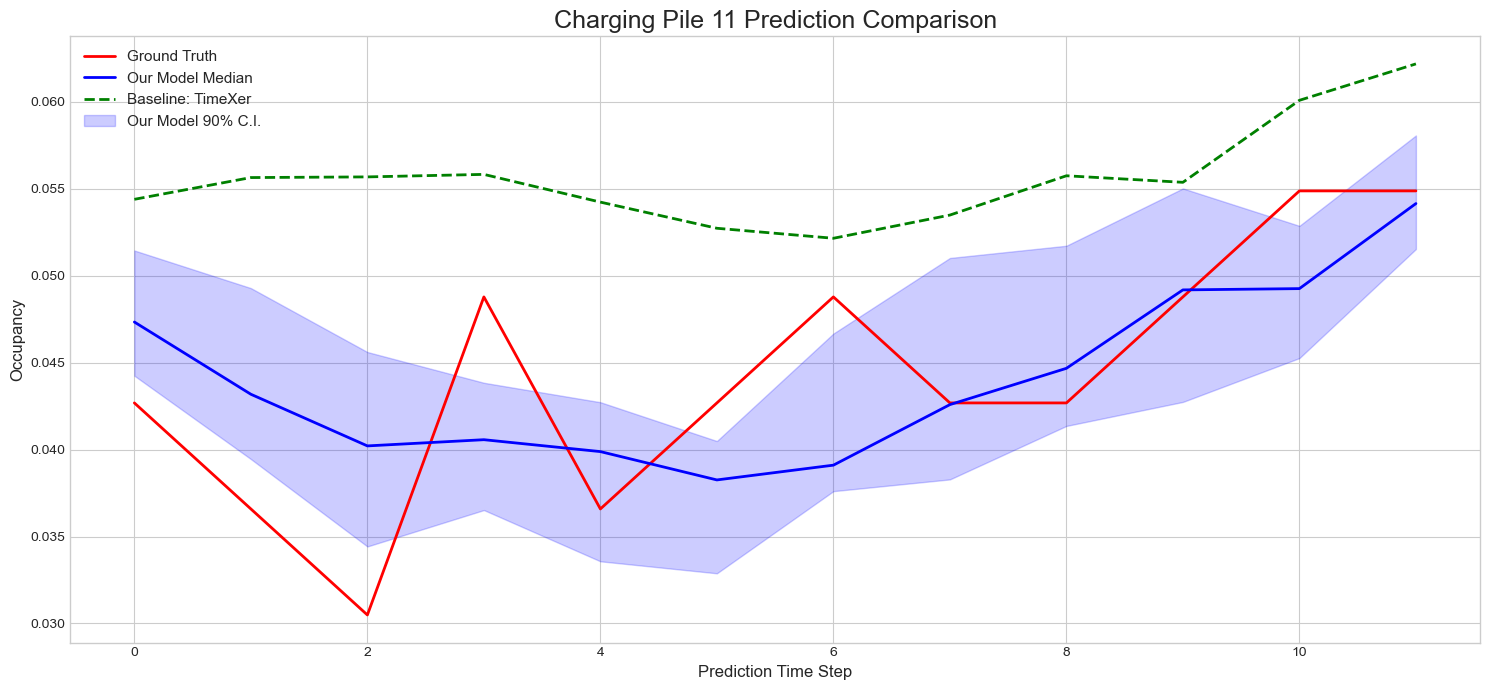

可视化图表已保存至: prediction_visualization.png


<Figure size 640x480 with 0 Axes>

In [52]:


# --- 2. 设置可视化参数 ---
sample_idx_to_plot = 1  # 选择第50个测试样本进行可视化
node_idx_to_plot = 11  # 选择第15个充电桩（节点）进行可视化

# --- 3. 准备绘图所需的数据 ---
# 提取特定样本和节点的数据
true_future = ground_truths[sample_idx_to_plot, :, node_idx_to_plot]
median_pred = model_predictions[sample_idx_to_plot, :, node_idx_to_plot]
all_samples = model_samples[sample_idx_to_plot, :, :, node_idx_to_plot]
baseline_pred = baseline_predictions[sample_idx_to_plot, :, node_idx_to_plot]

# --- 4. 调用绘图函数 ---
plot_timeseries_with_uncertainty(
    ground_truth=true_future,
    median_prediction=median_pred,
    prediction_samples=all_samples,
    baseline_prediction=baseline_pred,
    node_idx=node_idx_to_plot
)

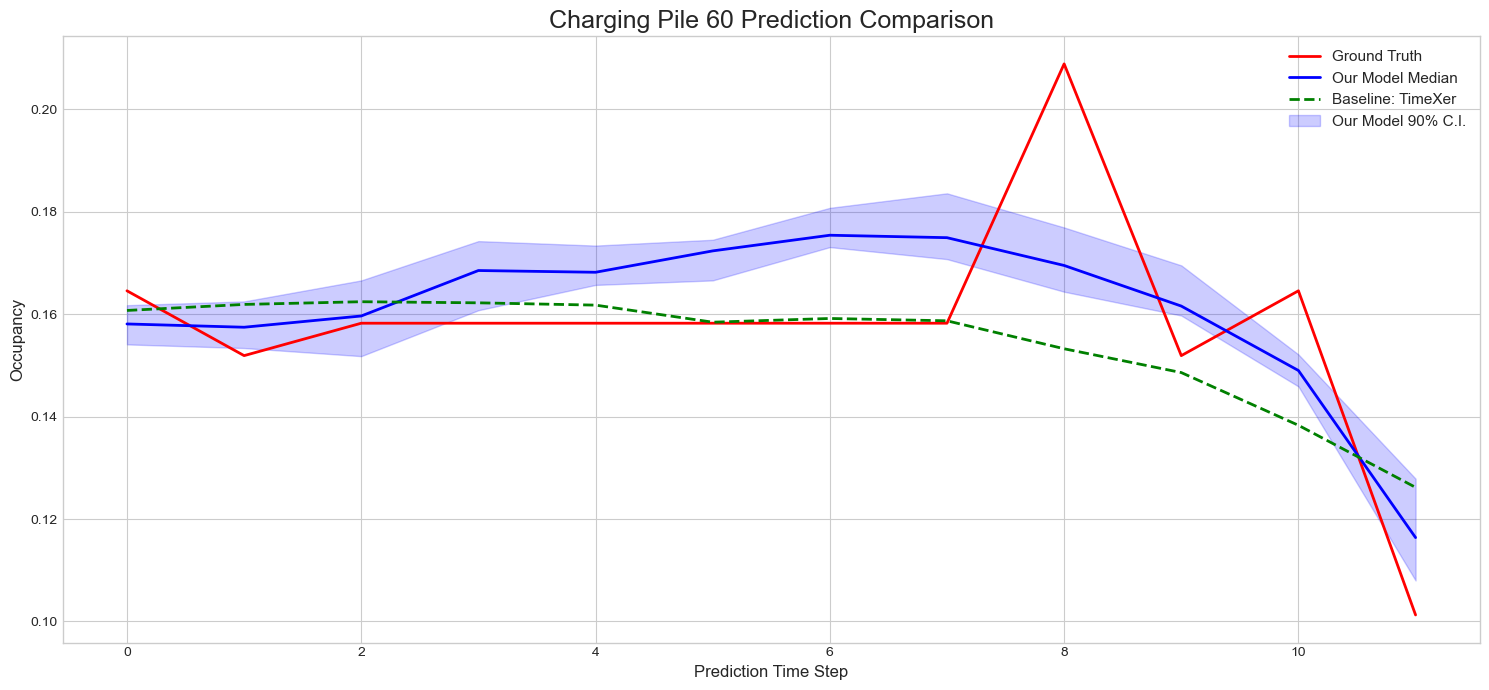

可视化图表已保存至: prediction_visualization.png


<Figure size 640x480 with 0 Axes>

In [53]:
# --- 2. 设置可视化参数 ---
sample_idx_to_plot = 60 # 选择第50个测试样本进行可视化
node_idx_to_plot = 60 # 选择第15个充电桩（节点）进行可视化

# --- 3. 准备绘图所需的数据 ---
# 提取特定样本和节点的数据
true_future = ground_truths[sample_idx_to_plot, :, node_idx_to_plot]
median_pred = model_predictions[sample_idx_to_plot, :, node_idx_to_plot]
all_samples = model_samples[sample_idx_to_plot, :, :, node_idx_to_plot]
baseline_pred = baseline_predictions[sample_idx_to_plot, :, node_idx_to_plot]

# --- 4. 调用绘图函数 ---
plot_timeseries_with_uncertainty(
    ground_truth=true_future,
    median_prediction=median_pred,
    prediction_samples=all_samples,
    baseline_prediction=baseline_pred,
    node_idx=node_idx_to_plot
)

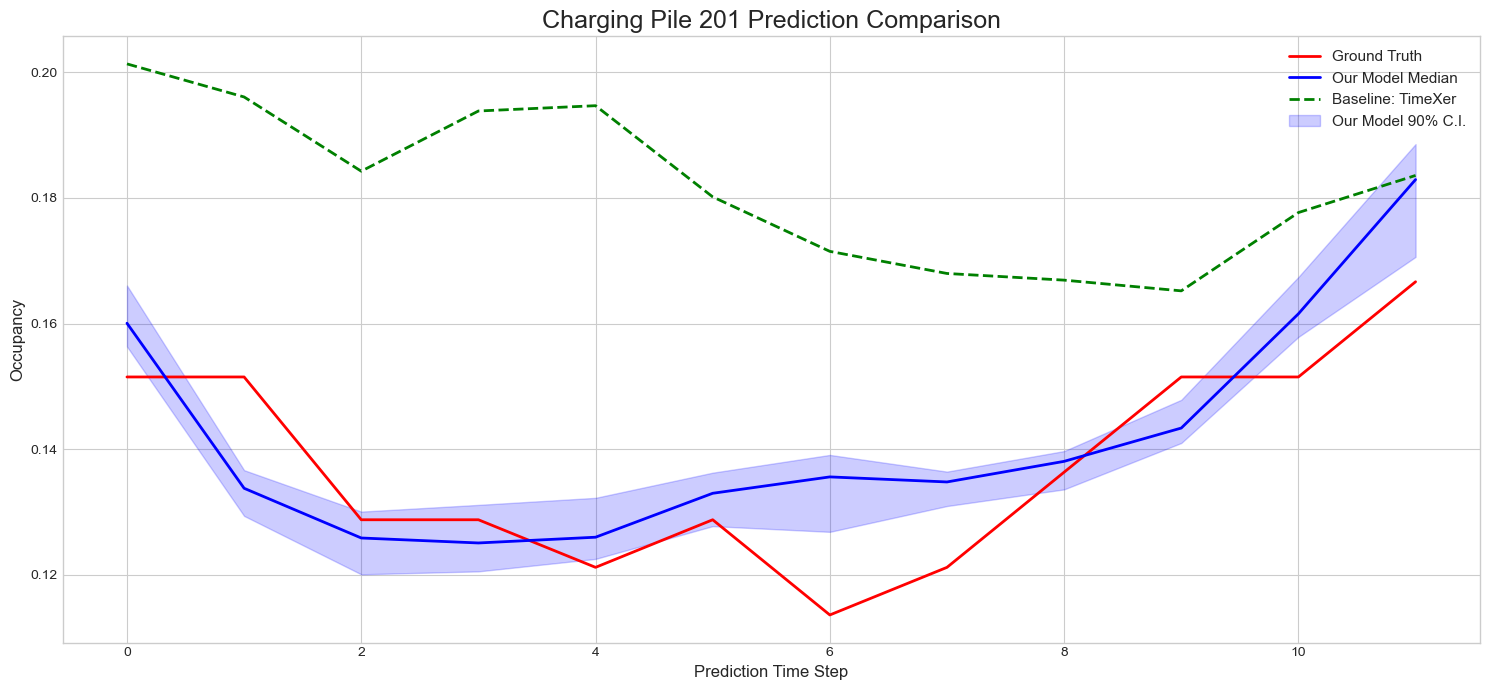

可视化图表已保存至: prediction_visualization.png


<Figure size 640x480 with 0 Axes>

In [54]:
# --- 2. 设置可视化参数 ---
sample_idx_to_plot = 72  # 选择第50个测试样本进行可视化
node_idx_to_plot = 201   # 选择第15个充电桩（节点）进行可视化

# --- 3. 准备绘图所需的数据 ---
# 提取特定样本和节点的数据
true_future = ground_truths[sample_idx_to_plot, :, node_idx_to_plot]
median_pred = model_predictions[sample_idx_to_plot, :, node_idx_to_plot]
all_samples = model_samples[sample_idx_to_plot, :, :, node_idx_to_plot]
baseline_pred = baseline_predictions[sample_idx_to_plot, :, node_idx_to_plot]

# --- 4. 调用绘图函数 ---
plot_timeseries_with_uncertainty(
    ground_truth=true_future,
    median_prediction=median_pred,
    prediction_samples=all_samples,
    baseline_prediction=baseline_pred,
    node_idx=node_idx_to_plot
)

In [58]:
address=pd.read_csv('urbanev/inf.csv')
address.sort_values(by="TAZID", ascending=True, inplace=True)
address

,TAZID,longitude,latitude,charge_count,area,perimeter
168,102,114.102962,22.540413,30,7.144193e+05,3501.2154
161,104,114.113986,22.553131,19,1.171734e+06,4683.8446
160,105,114.120846,22.551266,93,7.725567e+05,3472.0644
166,106,114.121880,22.544272,114,5.787174e+05,3486.9251
94,107,114.130389,22.544861,95,8.887169e+05,4445.4393
...,...,...,...,...,...,...
111,1166,114.127249,22.604594,161,2.372234e+06,6724.5788
98,1167,114.145276,22.599219,446,6.133971e+06,18053.4776
100,1168,114.048664,22.571472,43,1.441848e+06,8021.7389
101,1172,114.057007,22.572841,37,1.101210e+06,4761.0116


In [73]:
model_predictions.shape

(412, 12, 275)

In [22]:
def calculate_spatial_error(ground_truths, predictions, metric='mae'):
    """
    计算每个节点的指定指标 (MAE, RMSE, MAPE, RAE)。

    假定输入 shape 为 (B, L, N)，其中 N 是最后一个维度 (节点)。
    函数将在除最后一个维度之外的所有维度上聚合。

    参数:
    ground_truths (np.ndarray): 真实值数组。
    predictions (np.ndarray): 预测值数组。
    metric (str): 要计算的指标。可选值为:
                    'mae' (默认), 'rmse', 'mape', 'rae'

    返回:
    np.ndarray: 一个 shape 为 (N,) 的数组，包含每个节点的指标值。
    """
    
    # 确保是 numpy 数组
    ground_truths = np.asarray(ground_truths)
    predictions = np.asarray(predictions)
    
    if ground_truths.shape != predictions.shape:
        raise ValueError("ground_truths 和 predictions 必须具有相同的 shape")
    
    # 我们假设最后一个维度是节点(N)。
    # 我们将在所有其他维度上聚合 (例如, B 和 L)
    agg_axes = tuple(range(ground_truths.ndim - 1))
    
    # 用于防止除以零的极小值
    epsilon = 1e-9

    # --- 计算指标 ---
    
    if metric.lower() == 'mae':
        # 平均绝对误差
        abs_errors = np.abs(predictions - ground_truths)
        metric_per_node = np.mean(abs_errors, axis=agg_axes)
        
    elif metric.lower() == 'rmse':
        # 均方根误差
        squared_errors = np.square(predictions - ground_truths)
        mse_per_node = np.mean(squared_errors, axis=agg_axes)
        metric_per_node = np.sqrt(mse_per_node)

    elif metric.lower() == 'mse':
        # 均方根误差
        squared_errors = np.square(predictions - ground_truths)
        metric_per_node = np.mean(squared_errors, axis=agg_axes)
        
    elif metric.lower() == 'mape':
        # 平均绝对百分比误差
        abs_errors = np.abs(predictions - ground_truths)
        abs_gt = np.abs(ground_truths)
        
        # 创建一个掩码，只选择 gt 不为零的地方
        non_zero_mask = (abs_gt > epsilon)
        
        # 初始化百分比误差数组
        percentage_errors = np.zeros_like(ground_truths)
        
        # 仅在非零处计算百分比误差
        percentage_errors[non_zero_mask] = abs_errors[non_zero_mask] / abs_gt[non_zero_mask]
        
        # 为了正确计算平均值，我们需要用总和除以非零条目的 *数量*
        sum_pe_per_node = np.sum(percentage_errors, axis=agg_axes)
        non_zero_count_per_node = np.sum(non_zero_mask, axis=agg_axes)
        
        # 避免除以零 (如果某个节点所有真值都为0)
        metric_per_node = sum_pe_per_node / (non_zero_count_per_node + epsilon)
        metric_per_node = metric_per_node * 100 # 转换为百分比
        
    elif metric.lower() == 'rae':
        # 相对绝对误差
        abs_errors = np.abs(predictions - ground_truths)
        numerator = np.sum(abs_errors, axis=agg_axes) # Shape (N,)
        
        # 计算分母：真实值与其“节点平均值”之间的绝对误差总和
        # 使用 keepdims=True 来保持维度 (1, 1, N) 以便广播
        gt_mean_per_node_broadcast = np.mean(ground_truths, axis=agg_axes, keepdims=True)
        
        denominator_errors = np.abs(ground_truths - gt_mean_per_node_broadcast)
        denominator = np.sum(denominator_errors, axis=agg_axes) # Shape (N,)
        
        metric_per_node = numerator / (denominator + epsilon)
        
    else:
        raise ValueError(f"不支持的指标: {metric}. 可选值为: 'mae', 'rmse', 'mape', 'rae'")

    return metric_per_node

def plot_error_maps(our_model_error, baseline_error, locations):
    """
    绘制并排的两个空间误差分布热力图，用于对比。
    """

    plt.style.use('seaborn-v0_8-whitegrid')
    # --- 修改：使用 constrained_layout=True 来自动处理布局 ---
    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=True, sharey=True, constrained_layout=True)
    
    min_error = min(our_model_error.min(), baseline_error.min())
    max_error = max(our_model_error.max(), baseline_error.max())

    # 绘制左图：我们的模型
    ax1 = axes[0]
    scatter1 = ax1.scatter(
        locations[:, 0],  # 经度
        locations[:, 1],  # 纬度
        c=our_model_error,
        cmap='plasma_r',
        s=50,
        vmin=min_error,
        vmax=max_error
    )
    ax1.set_title("Our Model's Spatial Error Distribution", fontsize=18)
    ax1.set_xlabel('Longitude', fontsize=12)
    ax1.set_ylabel('Latitude', fontsize=12)
    ax1.grid(True)
    ax1.tick_params(axis='x', rotation=45)

    # 绘制右图：基线模型
    ax2 = axes[1]
    scatter2 = ax2.scatter(
        locations[:, 0],
        locations[:, 1],
        c=baseline_error,
        cmap='plasma_r',
        s=50,
        vmin=min_error,
        vmax=max_error
    )
    ax2.set_title("Baseline Model's Spatial Error Distribution", fontsize=18)
    ax2.set_xlabel('Longitude', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True)
    
    fig.colorbar(scatter2, ax=axes, orientation='vertical', label='MAE')
    
    fig.suptitle('Spatial Error Distribution Comparison', fontsize=22)
    plt.show()

In [20]:
def calculate_region_metrics(y_true, y_pred_median):
    metrics = {}

    # === 按区域的平均指标 ===
    # 维度: (batch, horizon, num_nodes) → 每个节点单独评估
    region_metrics = []
    for j in range(y_true.shape[2]):  # 遍历每个区域
        y_true_r = y_true[:, :, j]
        y_pred_r = y_pred_median[:, :, j]

        mae_r = float(np.mean(np.abs(y_pred_r - y_true_r)))
        rmse_r = float(np.sqrt(np.mean((y_pred_r - y_true_r) ** 2)))
        rae_r = float(np.sum(np.abs(y_pred_r - y_true_r)) / (np.sum(np.abs(np.mean(y_true_r) - y_true_r)) + 1e-9))
        non_zero_mask_r = y_true_r != 0
        mape_r = float(np.mean(np.abs((y_pred_r[non_zero_mask_r] - y_true_r[non_zero_mask_r]) / y_true_r[non_zero_mask_r])) * 100) if np.any(non_zero_mask_r) else 0.0

        region_metrics.append([ mae_r, rmse_r, rae_r, mape_r])

    df_region = pd.DataFrame(region_metrics, columns=['MAE', 'RMSE', 'RAE', 'MAPE'])

    # metrics['mae'] = float(df_region['MAE'].mean())
    # metrics['rmse'] = float(df_region['RMSE'].mean())
    # metrics['rae'] = float(df_region['RAE'].mean())
    # metrics['mape'] = float(df_region['MAPE'].mean())

    gc.collect()
    return df_region


正在从 address.csv 加载地理坐标...
正在从 address.csv 加载地理坐标...
正在检查经纬度为零的站点...
检查完毕，未发现经纬度为零的站点。
正在计算空间误差...
our_error: MAE     1.344043e-02
RMSE    1.962728e-02
RAE     5.100070e+07
MAPE    8.896108e+00
dtype: float64, baseline_error: MAE     3.776044e-02
RMSE    5.423676e-02
RAE     1.565484e+07
MAPE    2.161711e+01
dtype: float64
our_error shape: (275, 4), baseline_error shape: (275, 4)

正在生成空间误差对比图...


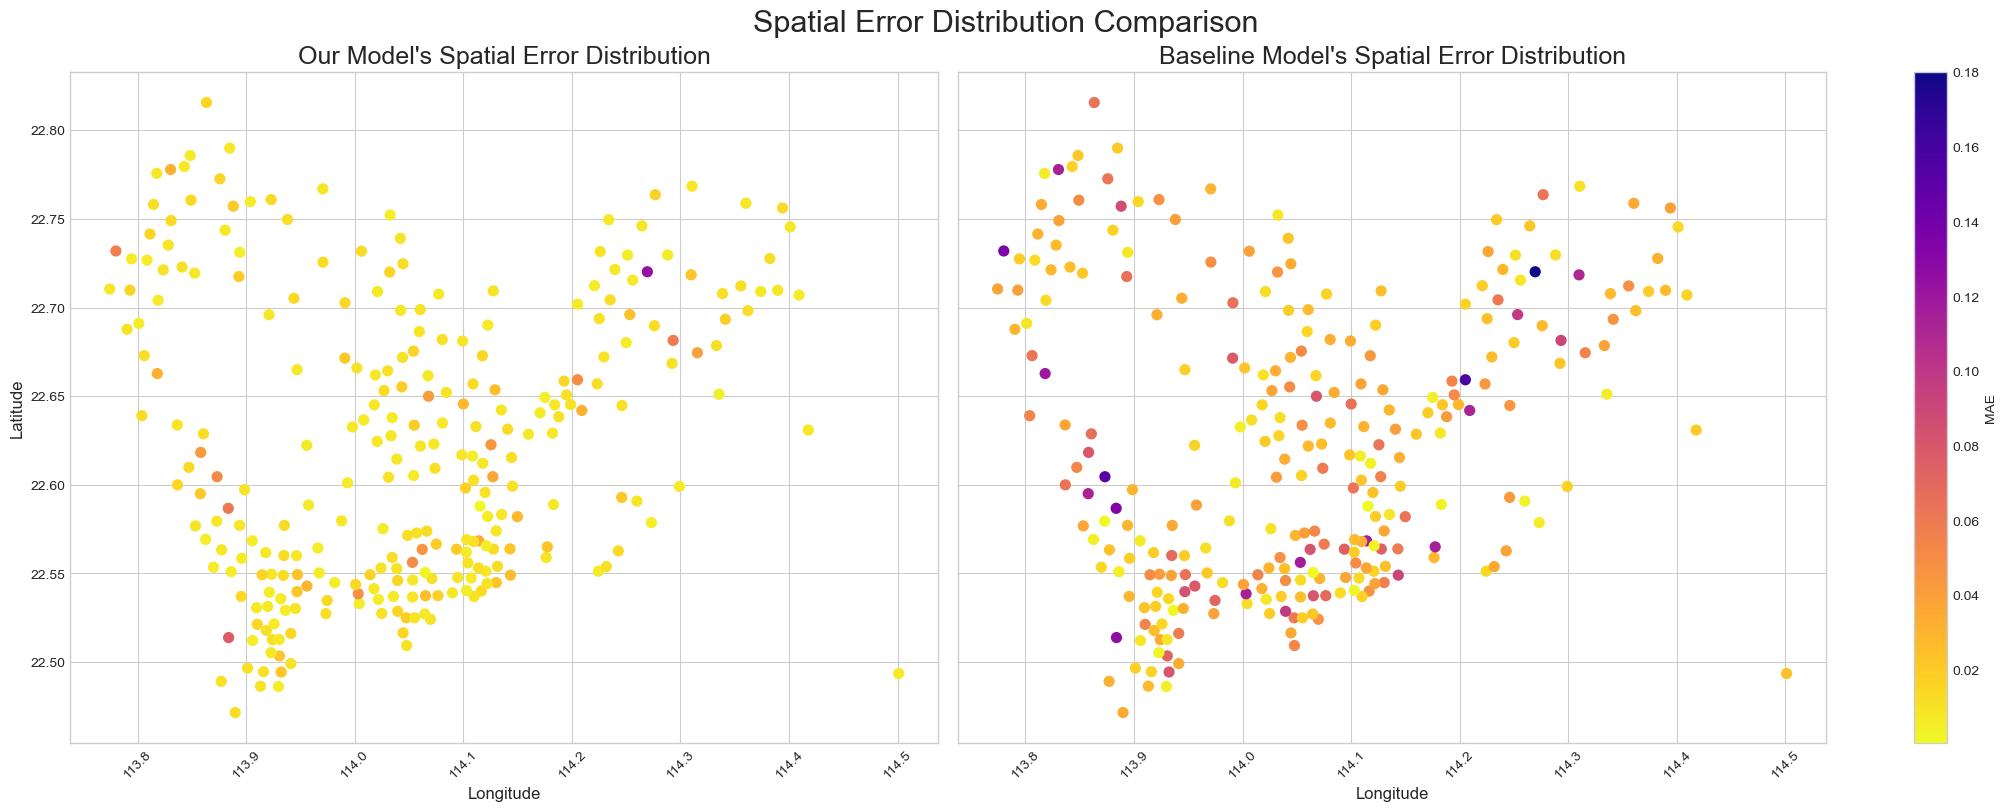

In [23]:
try:
    
    # --- 修改：从 address.csv 加载地理位置数据 ---
    print("正在从 address.csv 加载地理坐标...")
    print("正在从 address.csv 加载地理坐标...")
    address_df = pd.read_csv("urbanev/inf.csv")

    # --- 新增：查找并打印经纬度为零的站点 ---
    print("正在检查经纬度为零的站点...")
    zero_coord_stations = address_df[(address_df['longitude'] == 0) | (address_df['latitude'] == 0)]
    if not zero_coord_stations.empty:
        print("警告: 发现以下站点的经纬度为零或无效:")
        print(zero_coord_stations)
    else:
        print("检查完毕，未发现经纬度为零的站点。")
    
    # 从DataFrame中提取经纬度列，并转换为numpy数组
    node_locations = address_df[['longitude', 'latitude']].values

except FileNotFoundError as e:
    print(f"错误: 找不到数据文件 {e.filename}。请确保所有需要的.npy和.csv文件都存在。")
    # exit()

# --- 计算每个模型的空间误差 ---
print("正在计算空间误差...")
# our_error = calculate_spatial_error(ground_truths, model_predictions,'rmse')
# baseline_error = calculate_spatial_error(ground_truths, baseline_predictions,'rmse')

our_error= calculate_region_metrics(ground_truths, model_predictions)
baseline_error= calculate_region_metrics(ground_truths, baseline_predictions)

print(f"our_error: {our_error.mean()}, baseline_error: {baseline_error.mean()}")
print(f"our_error shape: {our_error.shape}, baseline_error shape: {baseline_error.shape}")

# --- 调用绘图函数 ---
print("\n正在生成空间误差对比图...")
plot_error_maps(
    our_model_error=our_error['MAE'],
    baseline_error=baseline_error['MAE'],
    locations=node_locations
)

In [24]:
import geopandas as gpd
# 读取shp文件
shp = gpd.read_file("urbanev/SZ_districts/SZ_districts.shp")
shp_ids = set(shp["TAZID"].unique())

# 读取csv文件
csv = pd.read_csv("urbanev/inf.csv")
csv_ids = set(csv["TAZID"].unique())

# 检查是否都包含
missing_ids = csv_ids - shp_ids

if len(missing_ids) == 0:
    print("✅ inf.csv 中的 TAZID 全部包含在 shp 文件中")
else:
    print("⚠ 有缺失的 TAZID：", missing_ids)

✅ inf.csv 中的 TAZID 全部包含在 shp 文件中


In [25]:

# 在 shp 中新增一列，存在则标记为 1，否则为 0
shp["in_csv"] = shp["TAZID"].apply(lambda x: 1 if x in csv_ids else 0)

正在从 address.csv 加载地理坐标...
正在检查经纬度为零的站点...
检查完毕，未发现经纬度为零的站点。
正在计算空间误差...

正在生成空间误差对比图...


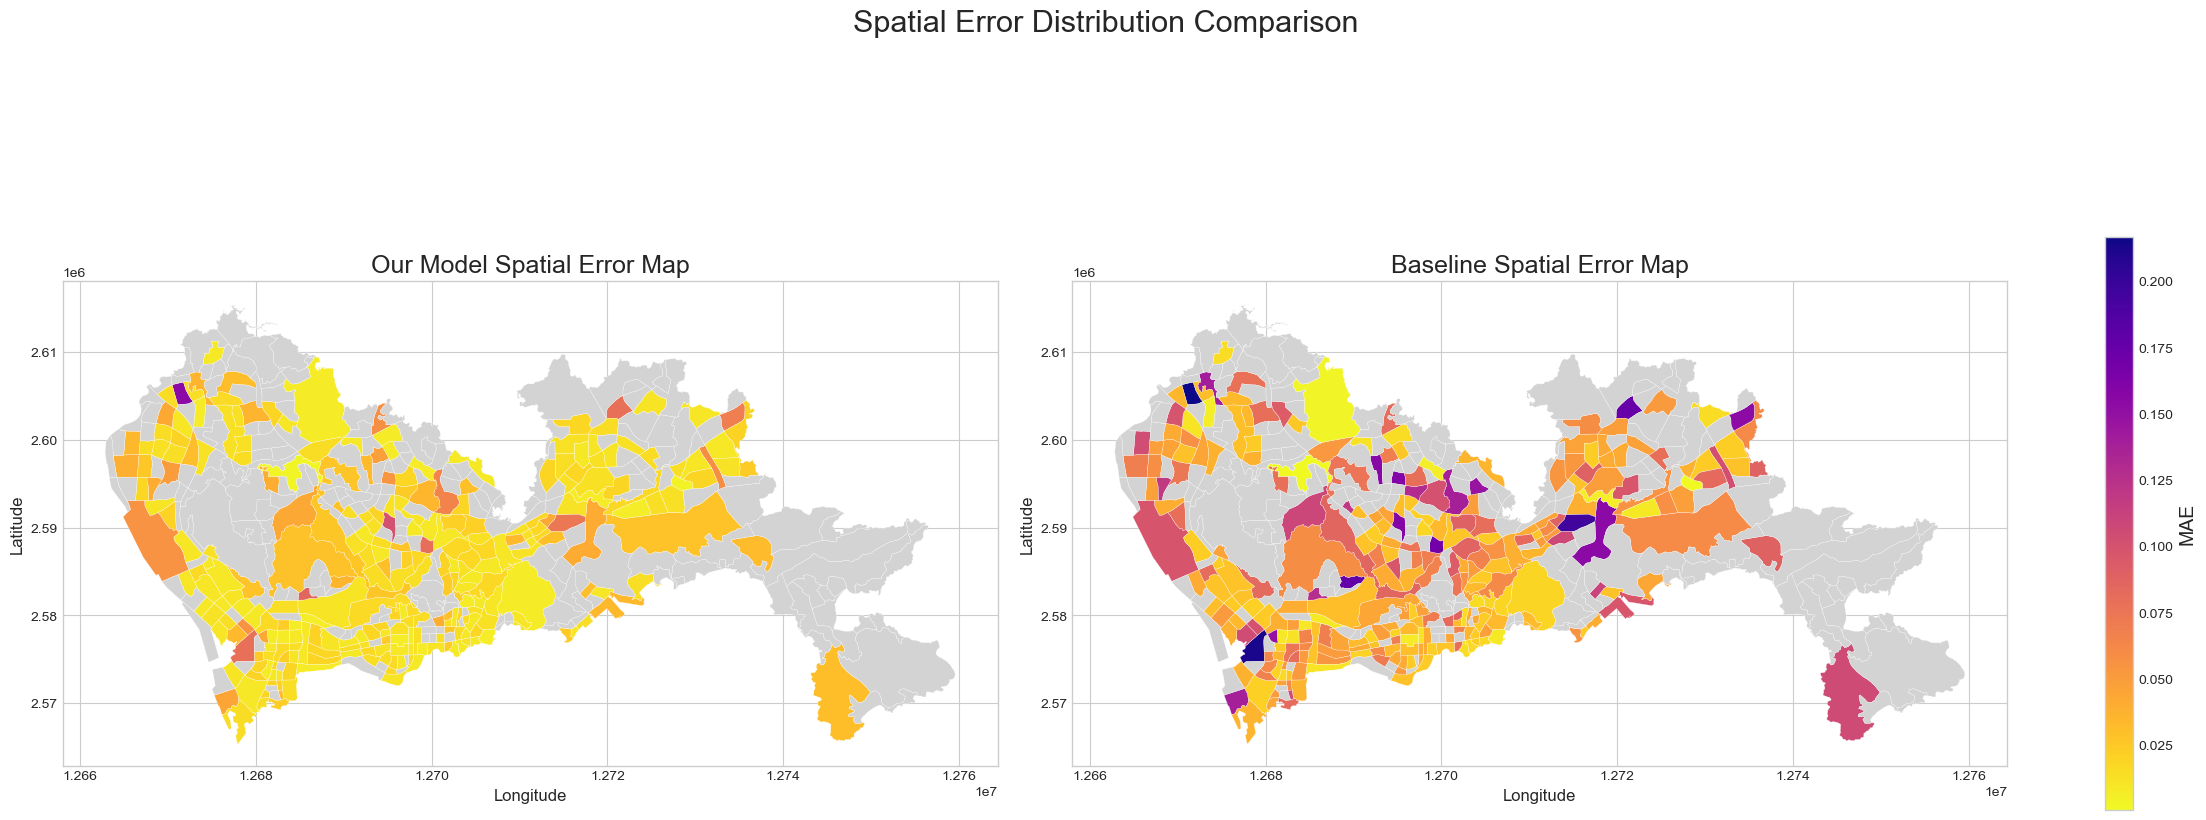

In [28]:
try:
    
    # --- 修改：从 address.csv 加载地理位置数据 ---
    print("正在从 address.csv 加载地理坐标...")
    address_df = pd.read_csv("urbanev/inf.csv")

    # --- 新增：查找并打印经纬度为零的站点 ---
    print("正在检查经纬度为零的站点...")
    zero_coord_stations = address_df[(address_df['longitude'] == 0) | (address_df['latitude'] == 0)]
    if not zero_coord_stations.empty:
        print("警告: 发现以下站点的经纬度为零或无效:")
        print(zero_coord_stations)
    else:
        print("检查完毕，未发现经纬度为零的站点。")
    
    # 从DataFrame中提取经纬度列，并转换为numpy数组
    node_locations = address_df[['longitude', 'latitude']].values

except FileNotFoundError as e:
    print(f"错误: 找不到数据文件 {e.filename}。请确保所有需要的.npy和.csv文件都存在。")
    # exit()

# --- 计算每个模型的空间误差 ---
print("正在计算空间误差...")
our_error = calculate_spatial_error(ground_truths, model_predictions,'rmse')
baseline_error = calculate_spatial_error(ground_truths, baseline_predictions,'rmse')

# --- 调用绘图函数 ---
print("\n正在生成空间误差对比图...")
plot_error_maps_with_shp_filled(
    shp=shp,
    our_model_error=our_error,
    baseline_error=baseline_error
)

正在从 address.csv 加载地理坐标...
正在检查经纬度为零的站点...
检查完毕，未发现经纬度为零的站点。
正在计算空间误差...
our_error: 0.019627276808023453, baseline_error: 0.05423673242330551

正在生成空间误差对比图...


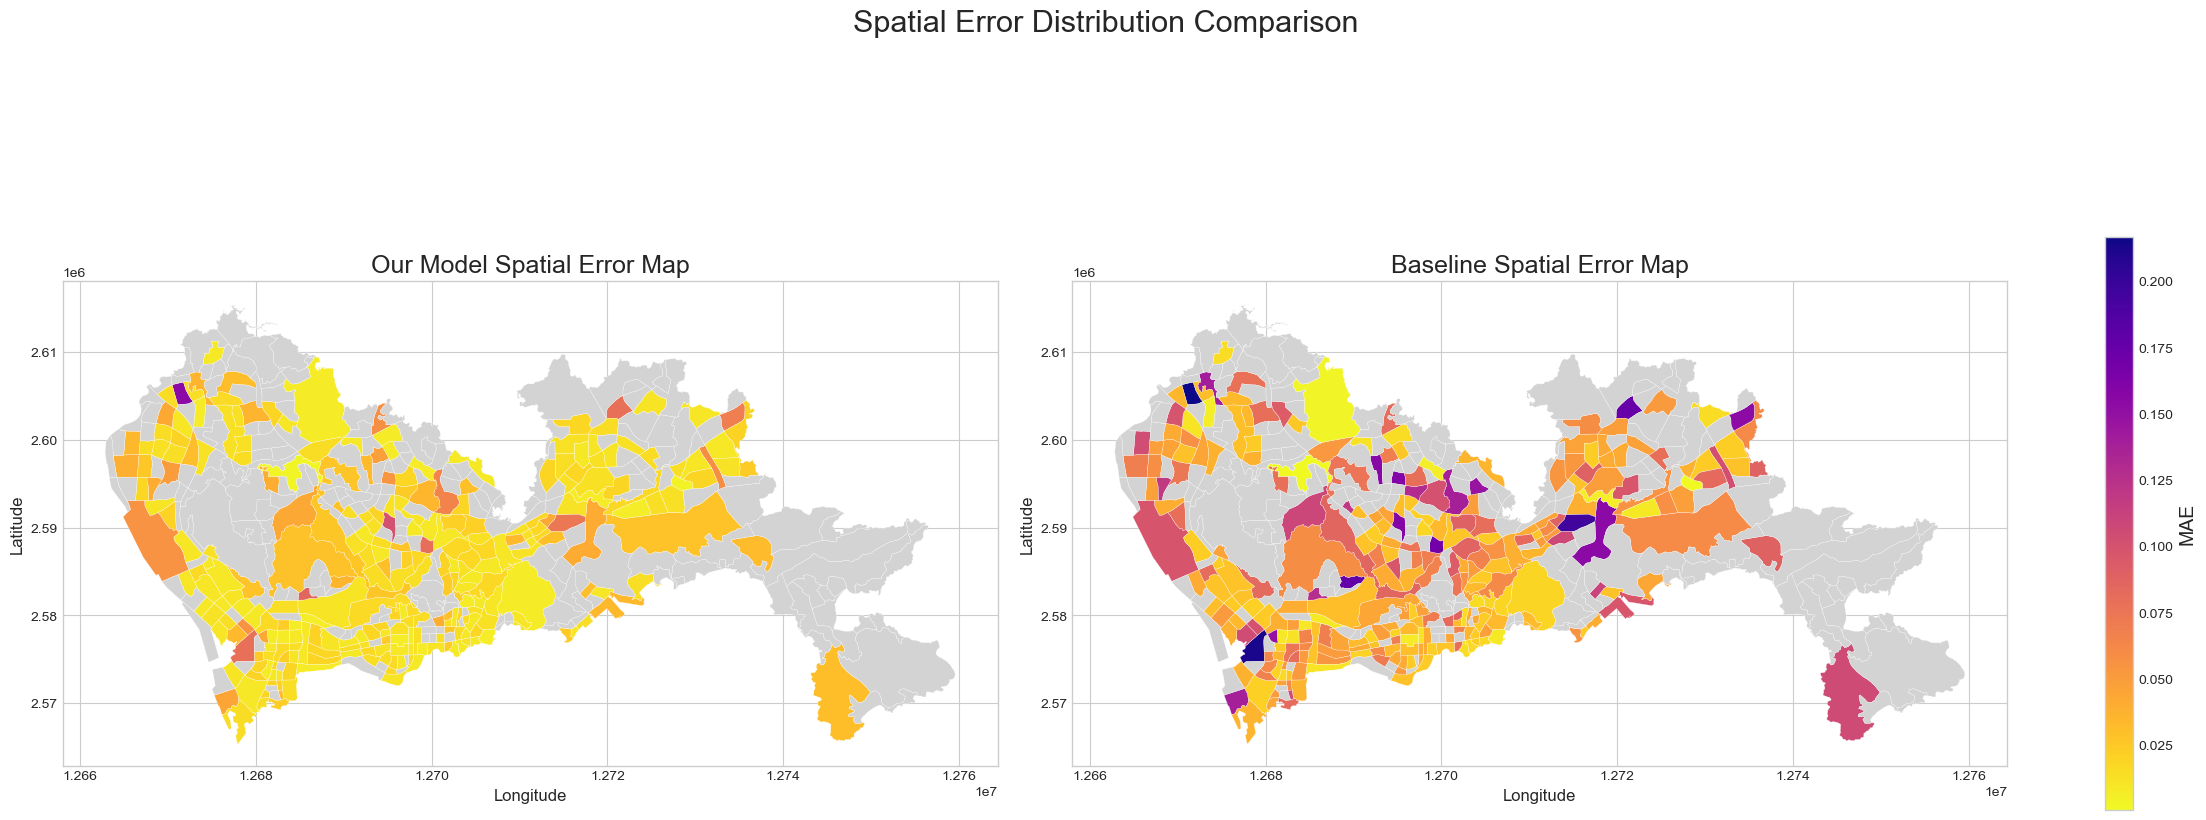

In [27]:
def plot_error_maps_with_shp_filled(shp, our_model_error, baseline_error):
    """
    依据误差对区域上色（Choropleth Map），无数据区域填充灰色。
    保留坐标轴与边框，适合论文展示。
    """

    # 复制 shp 防止修改原数据
    shp_plot = shp.copy()

    # 按 TAZID 排序，只给 in_csv==1 的区域填入误差值
    shp_plot = shp_plot.sort_values("TAZID").reset_index(drop=True)

    # 所有区域先标记为 NaN（即无数据区域）
    shp_plot["our_error"] = np.nan
    shp_plot["baseline_error"] = np.nan

    # 给有数据的区域填误差
    valid_mask = shp_plot["in_csv"] == 1
    shp_plot.loc[valid_mask, "our_error"] = our_model_error
    shp_plot.loc[valid_mask, "baseline_error"] = baseline_error

    # 色阶范围一致，便于对比
    vmin = min(np.nanmin(shp_plot["our_error"]), np.nanmin(shp_plot["baseline_error"]))
    vmax = max(np.nanmax(shp_plot["our_error"]), np.nanmax(shp_plot["baseline_error"]))

    fig, axes = plt.subplots(1, 2, figsize=(22, 10), constrained_layout=True)

    # --- 左图：Our Model ---
    shp_plot.plot(
        column="our_error",
        cmap="plasma_r",
        linewidth=0.2,
        edgecolor="white",            # ✅ 边框
        vmin=vmin, vmax=vmax,
        missing_kwds={                # ✅ 无数据区域填充灰色
            "color": "lightgrey",
            "edgecolor": "white",
            # "hatch": "//",
            "label": "No Data"
        },
        ax=axes[0]
    )
    axes[0].set_title("Our Model Spatial Error Map", fontsize=18)
    axes[0].set_xlabel("Longitude", fontsize=12)
    axes[0].set_ylabel("Latitude", fontsize=12)
    axes[0].grid(True)                # ✅ 保留坐标格网

    # --- 右图：Baseline Model ---
    shp_plot.plot(
        column="baseline_error",
        cmap="plasma_r",
        linewidth=0.2,
        edgecolor="white",            # ✅ 边框
        vmin=vmin, vmax=vmax,
        missing_kwds={
            "color": "lightgrey",
            "edgecolor": "white",
            "label": "No Data"
        },
        ax=axes[1]
    )
    axes[1].set_title("Baseline Spatial Error Map", fontsize=18)
    axes[1].set_xlabel("Longitude", fontsize=12)
    axes[1].set_ylabel("Latitude", fontsize=12)
    axes[1].grid(True)

    # ✅ 公共 Colorbar
    sm = plt.cm.ScalarMappable(cmap="plasma_r", norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, ax=axes, shrink=0.6, fraction=0.05)
    cbar.set_label("MAE", fontsize=14)

    fig.suptitle("Spatial Error Distribution Comparison", fontsize=22)
    plt.show()



try:
    
    # --- 修改：从 address.csv 加载地理位置数据 ---
    print("正在从 address.csv 加载地理坐标...")
    address_df = pd.read_csv("urbanev/inf.csv")

    # --- 新增：查找并打印经纬度为零的站点 ---
    print("正在检查经纬度为零的站点...")
    zero_coord_stations = address_df[(address_df['longitude'] == 0) | (address_df['latitude'] == 0)]
    if not zero_coord_stations.empty:
        print("警告: 发现以下站点的经纬度为零或无效:")
        print(zero_coord_stations)
    else:
        print("检查完毕，未发现经纬度为零的站点。")
    
    # 从DataFrame中提取经纬度列，并转换为numpy数组
    node_locations = address_df[['longitude', 'latitude']].values

except FileNotFoundError as e:
    print(f"错误: 找不到数据文件 {e.filename}。请确保所有需要的.npy和.csv文件都存在。")
    # exit()

# --- 计算每个模型的空间误差 ---
print("正在计算空间误差...")
our_error = calculate_spatial_error(ground_truths, model_predictions,'rmse')
baseline_error = calculate_spatial_error(ground_truths, baseline_predictions,'rmse')
print(f"our_error: {our_error.mean()}, baseline_error: {baseline_error.mean()}")

# --- 调用绘图函数 ---
print("\n正在生成空间误差对比图...")
plot_error_maps_with_shp_filled(
    shp=shp,
    our_model_error=our_error,
    baseline_error=baseline_error
)


In [29]:
def plot_error_diff_map(shp, our_model_error, baseline_error):
    """
    显示 our_model_error 相对 baseline_error 的提升/退化空间分布：
    - 绿色：our 模型更好（误差更小）
    - 红色：our 模型更差（误差更大）
    """
    shp_plot = shp.copy().sort_values("TAZID").reset_index(drop=True)

    # 差值（our - baseline），负数表示提升
    diff = our_model_error - baseline_error

    shp_plot["error_diff"] = np.nan
    valid_mask = shp_plot["in_csv"] == 1
    shp_plot.loc[valid_mask, "error_diff"] = diff

    # 对称色阶（正负平衡，便于直观比较）
    absmax = np.nanmax(np.abs(diff))

    fig, ax = plt.subplots(figsize=(10, 10), constrained_layout=True)

    shp_plot.plot(
        column="error_diff",
        cmap="RdYlGn_r",  # ✅ 红-黄-绿反转，绿色表示更好
        linewidth=0.2,
        edgecolor="white",
        vmin=-absmax, vmax=absmax,
        missing_kwds={
            "color": "lightgrey",
            "edgecolor": "white",
            "label": "No Data"
        },
        ax=ax
    )

    ax.set_title("Performance Difference (Our - Baseline)", fontsize=18)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)
    ax.grid(True)

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap="RdYlGn_r", norm=plt.Normalize(vmin=-absmax, vmax=absmax))
    sm._A = []
    cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
    cbar.set_label("Error Difference (Our - Baseline)", fontsize=14)
    cbar.ax.tick_params(labelsize=10)

    plt.show()

正在从 address.csv 加载地理坐标...
正在检查经纬度为零的站点...
检查完毕，未发现经纬度为零的站点。
正在计算空间误差...
our_error: 0.013440433889627457, baseline_error: 0.03776044026017189


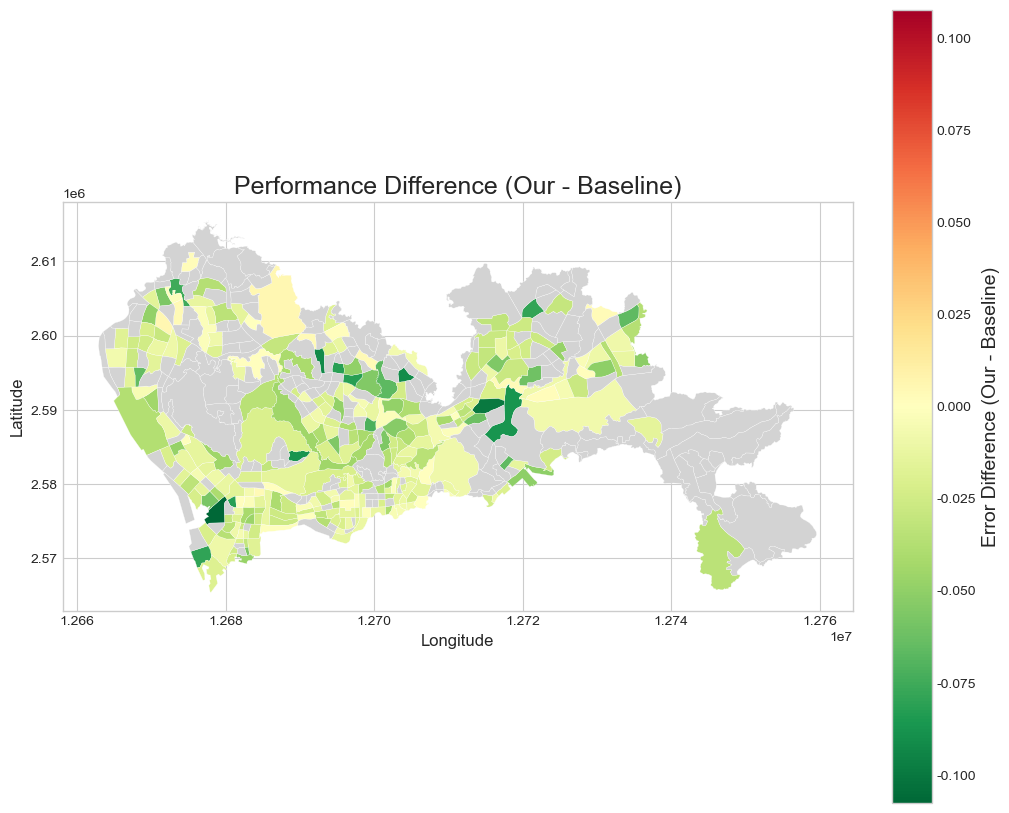

In [30]:
try:
    
    # --- 修改：从 address.csv 加载地理位置数据 ---
    print("正在从 address.csv 加载地理坐标...")
    address_df = pd.read_csv("urbanev/inf.csv")

    # --- 新增：查找并打印经纬度为零的站点 ---
    print("正在检查经纬度为零的站点...")
    zero_coord_stations = address_df[(address_df['longitude'] == 0) | (address_df['latitude'] == 0)]
    if not zero_coord_stations.empty:
        print("警告: 发现以下站点的经纬度为零或无效:")
        print(zero_coord_stations)
    else:
        print("检查完毕，未发现经纬度为零的站点。")
    
    # 从DataFrame中提取经纬度列，并转换为numpy数组
    node_locations = address_df[['longitude', 'latitude']].values

except FileNotFoundError as e:
    print(f"错误: 找不到数据文件 {e.filename}。请确保所有需要的.npy和.csv文件都存在。")
    # exit()

# --- 计算每个模型的空间误差 ---
print("正在计算空间误差...")
our_error = calculate_spatial_error(ground_truths, model_predictions,'mae')
baseline_error = calculate_spatial_error(ground_truths, baseline_predictions,'mae')
print(f"our_error: {our_error.mean()}, baseline_error: {baseline_error.mean()}")

# --- 调用绘图函数 ---
plot_error_diff_map(
    shp=shp,
    our_model_error=our_error,
    baseline_error=baseline_error
)



In [31]:
a=our_error-baseline_error
a=a[a<0]


In [32]:
a.shape

(258,)

In [34]:
import seaborn as sns

--- 概率预测评估脚本 ---

--- 正在计算 PIT 直方图 ---


C:\Users\ll\AppData\Local\Temp\ipykernel_17172\799534807.py:117: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  plt.savefig(pit_hist_path)
C:\Users\ll\AppData\Local\Temp\ipykernel_17172\799534807.py:117: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.savefig(pit_hist_path)
C:\Users\ll\AppData\Local\Temp\ipykernel_17172\799534807.py:117: UserWarning: Glyph 30452 (\N{CJK UNIFIED IDEOGRAPH-76F4}) missing from current font.
  plt.savefig(pit_hist_path)
C:\Users\ll\AppData\Local\Temp\ipykernel_17172\799534807.py:117: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from current font.
  plt.savefig(pit_hist_path)
C:\Users\ll\AppData\Local\Temp\ipykernel_17172\799534807.py:117: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.savefig(pit_hist_path)
C:\Users\ll\AppData\Local\Temp\ipykernel_17172\799534807.py:117: UserWarning: Glyph 20540 (\N{CJK UNIFIED

PIT 直方图已保存到: pit_histogram.png

--- 正在计算可靠性图 ---
可靠性图已保存到: reliability_diagram.png


c:\Users\ll\.conda\envs\UrbanEV\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ll\.conda\envs\UrbanEV\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ll\.conda\envs\UrbanEV\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30452 (\N{CJK UNIFIED IDEOGRAPH-76F4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ll\.conda\envs\UrbanEV\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ll\.conda\envs\UrbanEV\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current fon

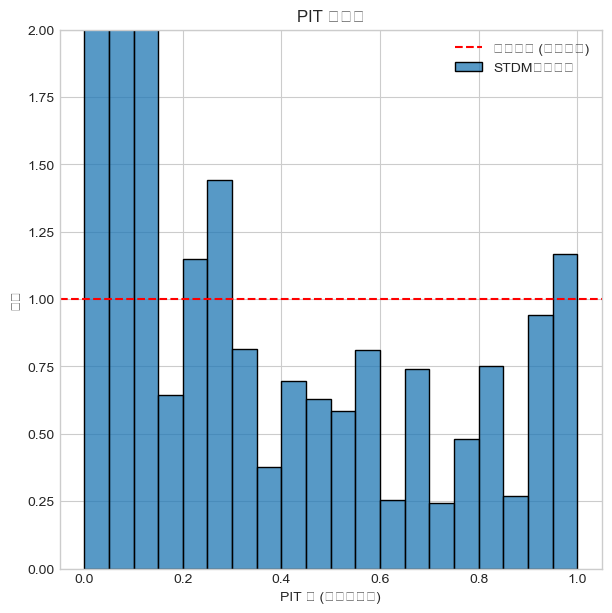

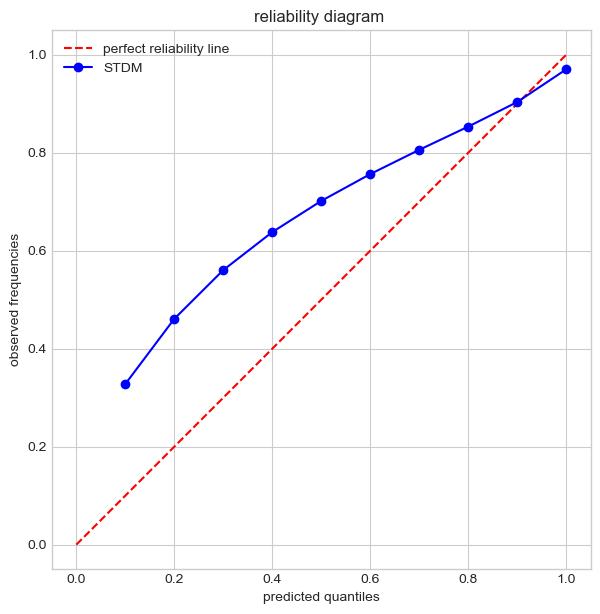

In [35]:
def calculate_pit(y_true, y_pred_samples):
    """
    计算概率积分变换 (PIT) 值。
    
    这是评估概率预测校准度的核心工具。
    它计算的是真实值 (y_true) 相对于预测样本 (y_pred_samples) 的经验分位数。
    
    参数:
    y_true (np.ndarray): 真实值数组。
                          形状: (B, L, N) 或 (num_datapoints,)
    y_pred_samples (np.ndarray): 预测样本数组。
                                  形状: (B, S, L, N) 或 (num_datapoints, S)
                                  其中 S 是样本数量。

    返回:
    np.ndarray: 一维数组，包含所有数据点的 PIT 值 (范围在 0 到 1 之间)。
                如果预测完美校准，此数组应服从均匀分布。
    """
    
    # 为了进行广播比较，我们需要将 y_true 的形状扩展为 (B, 1, L, N)
    # 以便它能和 (B, S, L, N) 的 y_pred_samples 进行比较。
    if y_true.ndim == 3 and y_pred_samples.ndim == 4:
        # 假设 y_true: (B, L, N), y_pred_samples: (B, S, L, N)
        # B = 批量大小, L = 预测长度, N = 节点数, S = 样本数
        y_true_expanded = np.expand_dims(y_true, axis=1) # 形状变为 (B, 1, L, N)
        sample_axis = 1 # 样本在 S 维度上
    elif y_true.ndim == 1 and y_pred_samples.ndim == 2:
        # 假设 y_true: (N,), y_pred_samples: (N, S)
        y_true_expanded = np.expand_dims(y_true, axis=1) # 形状变为 (N, 1)
        sample_axis = 1 # 样本在 S 维度上
    else:
        raise ValueError(f"输入形状不匹配！y_true: {y_true.shape}, y_pred_samples: {y_pred_samples.shape}")

    # (y_pred_samples <= y_true_expanded) 会生成一个布尔数组
    # np.mean(..., axis=sample_axis) 会计算布尔值为 True 的比例，
    # 这等同于 (count(samples <= true_value) / num_samples)
    pit_values = np.mean(y_pred_samples <= y_true_expanded, axis=sample_axis)
    
    # 返回所有 PIT 值的一维数组，以便绘制直方图
    return pit_values.flatten()

def calculate_reliability_diagram(y_true, y_pred_samples, num_bins=10):
    """
    计算可靠性图 (Reliability Diagram) 的数据点。

    参数:
    y_true (np.ndarray): 真实值数组。形状 (B, L, N) 或 (num_datapoints,)
    y_pred_samples (np.ndarray): 预测样本数组。形状 (B, S, L, N) 或 (num_datapoints, S)
    num_bins (int): 要检查的分位数“箱子”的数量 (例如 10，将检查 0.1, 0.2, ..., 1.0)。

    返回:
    tuple: (expected_quantiles, observed_frequencies)
           - expected_quantiles (np.ndarray): 目标分位数 (例如 [0.1, 0.2, ..., 1.0])
           - observed_frequencies (np.ndarray): 真实值低于该预测分位数的实际频率
    """
    
    if y_true.ndim == 3 and y_pred_samples.ndim == 4:
        sample_axis = 1
    elif y_true.ndim == 1 and y_pred_samples.ndim == 2:
        sample_axis = 1
    else:
        raise ValueError(f"输入形状不匹配！y_true: {y_true.shape}, y_pred_samples: {y_pred_samples.shape}")

    # 1. 定义我们想要检查的目标分位数（x轴）
    # 例如 num_bins=10, 结果为 [0.1, 0.2, ..., 1.0]
    expected_quantiles = np.linspace(0, 1, num_bins + 1)[1:]

    # 2. 从预测样本中计算这些分位数的“预测值”
    # q=expected_quantiles, axis=sample_axis
    # predicted_quantiles 的形状: (Q, B, L, N) 或 (Q, N)
    predicted_quantiles = np.quantile(y_pred_samples, q=expected_quantiles, axis=sample_axis)

    # 3. 检查真实值 (y_true) 在多大频率上低于这些“预测值”
    
    # (B, L, N) -> (1, B, L, N) 或 (N,) -> (1, N)
    y_true_expanded = np.expand_dims(y_true, axis=0) 
    
    # (y_true_expanded <= predicted_quantiles)
    # 广播比较 (1, B, L, N) <= (Q, B, L, N)
    # 结果 observed_booleans 形状为 (Q, B, L, N)
    observed_booleans = (y_true_expanded <= predicted_quantiles)
    
    # 沿着所有非分位数轴 (B, L, N) 计算均值，得到每个分位数的实际频率
    data_axes = tuple(range(1, y_true_expanded.ndim)) # (1, 2, 3) 或 (1,)
    observed_frequencies = np.mean(observed_booleans, axis=data_axes)
    
    return expected_quantiles, observed_frequencies


print("--- 概率预测评估脚本 ---")



# 定义数据形状
B = 500  # 批量大小 (数据点数量)
L = 12   # 预测长度
N = 275  # 节点数
S = 40   # 样本数 (NUM_SAMPLES)


# --- 2. 计算并绘制 PIT 直方图 ---
print("\n--- 正在计算 PIT 直方图 ---")
pit_values_calibrated = calculate_pit(ground_truths, model_samples)


plt.figure(figsize=(7, 7))
sns.histplot(pit_values_calibrated, bins=20, kde=False, stat="density", label="STDM模型分布")
plt.axhline(1.0, color='red', linestyle='--', label='完美校准 (均匀分布)')
plt.title('PIT 直方图')
plt.xlabel('PIT 值 (经验分位数)')
plt.ylabel('密度')
plt.legend()
plt.ylim(0, 2) # 设置Y轴范围以便比较


pit_hist_path = 'pit_histogram.png'
plt.savefig(pit_hist_path)
print(f"PIT 直方图已保存到: {pit_hist_path}")

# --- 3. 计算并绘制可靠性图 ---
print("\n--- 正在计算可靠性图 ---")
expected_q, observed_freq_calibrated = calculate_reliability_diagram(ground_truths, model_samples)

plt.figure(figsize=(7, 7))

plt.plot([0, 1], [0, 1], 'r--', label='perfect reliability line')
plt.plot(expected_q, observed_freq_calibrated, 'bo-', label='STDM')
plt.title('reliability diagram ')
plt.xlabel('predicted quantiles')
plt.ylabel('observed frequencies')
plt.axis('square') # 确保x和y轴等比例
plt.legend()
plt.grid(True)

reliability_diag_path = 'reliability_diagram.png'
plt.savefig(reliability_diag_path)
print(f"可靠性图已保存到: {reliability_diag_path}")

In [ ]:
shp_df = shp[["TAZID", "X", "Y"]].copy()
csv_df = csv[["TAZID", "longitude", "latitude"]].copy()

# 按 TAZID 对齐
merged = pd.merge(
    shp_df, csv_df,
    on="TAZID",
    suffixes=("_shp", "_csv"),
    how="inner"
)

# 检查是否一致
merged["lon_equal"] = merged["X"] == merged["longitude"]
merged["lat_equal"] = merged["Y"] == merged["latitude"]

# 找出不一致的记录
diff = merged[(~merged["lon_equal"]) | (~merged["lat_equal"])]

if diff.empty:
    print("✅ inf.csv 和 shp 中相同 TAZID 的经纬度完全一致")
else:
    print("⚠ 发现经纬度不一致的记录：")
    print(diff[["TAZID", "X", "Y", "longitude", "latitude"]])

✅ inf.csv 和 shp 中相同 TAZID 的经纬度完全一致


In [ ]:
true_baseline = np.load("results/trues.npy")

In [ ]:
true_baseline.shape

(412, 12, 275)

In [ ]:
ground_truths.shape

(412, 12, 275)